### What are cosine sim plot to compliment cross decoding for pref/not-pref using sub-pops?

In [12]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
from scripts.anova_analysis.anova_configs import *

import scipy
import argparse
import copy
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: xlabel='Time_y', ylabel='Time_x'>

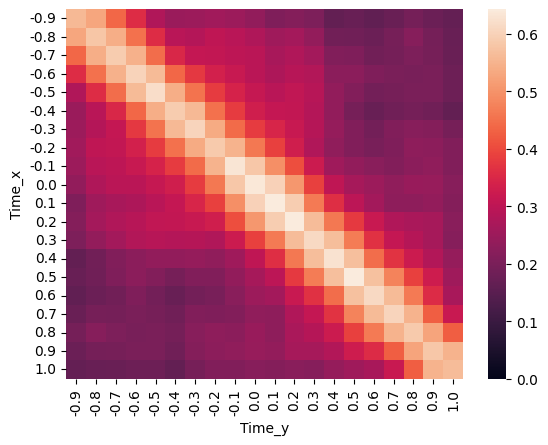

In [28]:
args = argparse.Namespace(
    **SingleSelectedFeatureConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "PreferredChosen": True}
args.shuffle_method = "session_permute"
args.sig_unit_level = "95th_all_time"

# res = io_utils.read_selected_features(args, FEATURES, conds=["pref_vs_not_pref"])

fig, ax = plt.subplots()

models = io_utils.read_selected_features_models(args, FEATURES, "pref_vs_not_pref")
weights = io_utils.get_selected_features_weights(models)
cosine_sims = classifier_utils.get_cross_time_cosine_sim_of_weights(weights)
sns.heatmap(cosine_sims, ax=ax, vmin=0)
# axs[i].set_title(cond)


<Axes: xlabel='Time_y', ylabel='Time_x'>

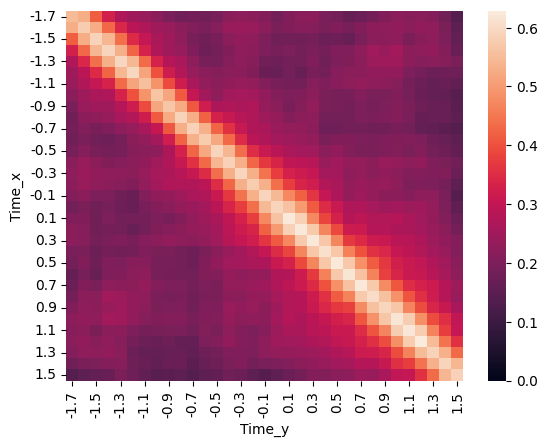

In [29]:
args = argparse.Namespace(
    **SingleSelectedFeatureConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "PreferredChosen": True}
args.shuffle_method = "session_permute"
args.sig_unit_level = "95th_all_time"
args.trial_event = "FeedbackOnsetLong"

# res = io_utils.read_selected_features(args, FEATURES, conds=["pref_vs_not_pref"])

fig, ax = plt.subplots()

models = io_utils.read_selected_features_models(args, FEATURES, "pref_vs_not_pref")
weights = io_utils.get_selected_features_weights(models)
cosine_sims = classifier_utils.get_cross_time_cosine_sim_of_weights(weights)
sns.heatmap(cosine_sims, ax=ax, vmin=0)
# axs[i].set_title(cond)


### Can I split up units into persistent vs. non-persistent ones? 
Take the -1800 and 0, and 0-1500 intervals, plot cosine sim for units that are shared bteween them, and not
Hope to see: matrix breaks out into chunks

In [44]:
# event = "FeedbackOnsetLong"
# range1 = [-1800, 0]
# range2 = [0, 1500]

event = "StimOnset"
range1 = [-1000, 0]
range2 = [0, 1000]

In [45]:
args = argparse.Namespace(
    **SingleSelectedFeatureConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "PreferredChosen": True}
args.shuffle_method = "session_permute"
args.sig_unit_level = "95th_all_time"
args.trial_event = event

# res = io_utils.read_selected_features(args, FEATURES, conds=["pref_vs_not_pref"])
models = io_utils.read_selected_features_models(args, FEATURES, "pref_vs_not_pref")
weights = io_utils.get_selected_features_weights_with_ids(args, FEATURES, "pref_vs_not_pref")


In [46]:
def weights_to_weights_list(weights):
    """
    grabs df with weights with pseudo unit ids
    converts to weights as list per run, feat, time
    """
    def list_weights(group):
        group = group.sort_values(by="PseudoUnitID")
        return group.weight.values
    return weights.groupby(["Time", "run", "feat"]).apply(list_weights).reset_index(name="weights")


Find persistent units

In [47]:
sig_level = "95th"

args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = event
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = range1
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
dec_res = io_utils.read_anova_good_units(args, sig_level)

args.time_range = range2
fb_res = io_utils.read_anova_good_units(args, sig_level)

persistent_units = fb_res[fb_res.PseudoUnitID.isin(dec_res.PseudoUnitID)].PseudoUnitID.unique()


In [48]:
non_pers_weights = weights[~weights.PseudoUnitID.isin(persistent_units)]
pers_weights =  weights[weights.PseudoUnitID.isin(persistent_units)]

non_pers_weights = weights_to_weights_list(non_pers_weights)
pers_weights = weights_to_weights_list(pers_weights)

In [49]:
pers_weights

,Time,run,feat,weights
0,-0.9,0,CIRCLE,"[-0.110384114, 0.16366322, -0.073026605, -0.01..."
1,-0.9,0,CYAN,"[0.01606707, 0.07620876, 0.1635623, -0.0713373..."
2,-0.9,0,ESCHER,"[0.10881864, -0.017321777, 0.058684643, 0.0375..."
3,-0.9,0,GREEN,"[-0.2046667, 0.079514034, -0.0023323637, 0.171..."
4,-0.9,0,MAGENTA,"[-0.018948998, 0.17311649, -0.042891487, -0.00..."
...,...,...,...,...
1915,1.0,7,SQUARE,"[0.09303502, 0.21838365, -0.07998174, 0.066746..."
1916,1.0,7,STAR,"[0.016997468, 0.083263725, 0.18767269, -0.2634..."
1917,1.0,7,SWIRL,"[-0.038713507, -0.033905234, 0.078338176, -0.2..."
1918,1.0,7,TRIANGLE,"[0.21350053, 0.048538677, 0.09054569, 0.155808..."


<Axes: xlabel='Time_y', ylabel='Time_x'>

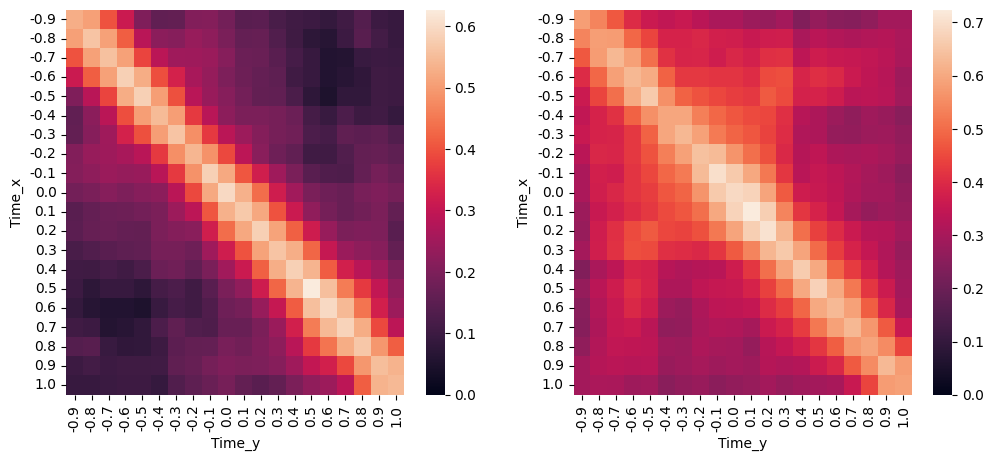

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

non_pers_sims = classifier_utils.get_cross_time_cosine_sim_of_weights(non_pers_weights)
sns.heatmap(non_pers_sims, ax=ax1, vmin=0)

pers_sims = classifier_utils.get_cross_time_cosine_sim_of_weights(pers_weights)
sns.heatmap(pers_sims, ax=ax2, vmin=0)

229

### What should baseline be here? 
- Different features have different # of neurons, diff dims 
- Plotting average cosine sim across features, averaging across runs, feats
- null: generate same data 1000 times, randomly drawing vectors

In [24]:
stimonset_units = pd.read_pickle("/data/patrick_res/firing_rates/SA/StimOnset_pref_95th_all_time_units.pickle")
stimonset_units = stimonset_units.groupby("feat").PseudoUnitID.nunique().to_dict()

In [25]:
num_shuffle = 1000
num_runs = 8

def random_vector(n):
    vec = np.random.normal(0, 1, n)  # Generate random numbers from normal distribution
    return vec

avg_cosin_sims = []
for i in tqdm(range(num_shuffle)):
    avg_cosine_sim = []
    for feat in FEATURES: 
        n = stimonset_units[feat]
        for run_x in range(num_runs):
            for run_y in range(num_runs):
                if run_x != run_y:
                    sim = classifier_utils.cosine_sim(random_vector(n), random_vector(n))
                    avg_cosine_sim.append(sim)
    avg_cosin_sims.append(np.mean(avg_cosine_sim))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 166.33it/s]


In [27]:
np.percentile(avg_cosin_sims, 99)

0.016642164876774255